# Text Clustering


## Need datasets are in the current folder structure in the github repo
## Look for 'adjustable' comments to adjust various settings

```
Author: hong cui
Dataset:iSamples
```

In [1]:
from platform import python_version
print(python_version()) #3.9.7

3.9.7


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import fasttext # pip install fasttext-0.9.2-cp310-cp310-win_amd64.whl
import matplotlib.pyplot as plt 
import pickle
from joblib import Parallel, delayed
from sklearn.cluster import Birch
import fastcluster
from scipy.cluster.hierarchy import fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


### Load and preprocess data: selective fields


In [3]:
ds = "SMITHSONIAN"

data = pd.read_csv(ds+'.txt',sep='#', keep_default_na=False)

data.columns.tolist()
df_content = pd.DataFrame()
#adjustable: select different (conbinations) of the files for 'orginal'
df_content['original'] = data['habitat']
df_content = df_content.replace(r'^\s*$', np.NaN, regex=True)
df_content.shape[0] #29881
df_content
df_content = df_content.dropna(how='any').reset_index(drop=True)
df_content.shape[0]#178932
df_content.columns
df_content.shape[0]
df_content.iloc[3]




['year',
 'recordedBy',
 'georeferenceProtocol',
 'genus',
 'typeStatus',
 'scientificName',
 'associatedSequences',
 'decimalLatitude',
 'higherClassification',
 'maximumElevationInMeters',
 'identificationQualifier',
 'fieldNumber',
 'occurrenceID',
 'decimalLongitude',
 'type',
 'minimumDepthInMeters',
 'family',
 'minimumElevationInMeters',
 'sex',
 'subgenus',
 'verbatimElevation',
 'maximumDepthInMeters',
 'institutionCode',
 'materialSampleID',
 'verbatimCoordinateSystem',
 'collectionCode',
 'class',
 'order',
 'lifeStage',
 'stateProvince',
 'verbatimLatitude',
 'verbatimLongitude',
 'endDayOfYear',
 'associatedOccurrences',
 'coordinateUncertaintyInMeters',
 'habitat',
 'disposition',
 'geodeticDatum',
 'individualCount',
 'verbatimEventDate',
 'specificEpithet',
 'identifiedBy',
 'islandGroup',
 'recordNumber',
 'references',
 'kingdom',
 'preparations',
 'startDayOfYear',
 'infraspecificEpithet',
 'phylum',
 'catalogNumber',
 'higherGeography',
 'scientificNameAuthorship',


194517

,original
0,NaN
1,NaN
2,NaN
3,NaN
4,Primary terra firma forest with tall (3-5 m) u...
...,...
194512,"with Opuntia, Muhlenbergia, Chloris, Acacia, E..."
194513,NaN
194514,NaN
194515,NaN


29881

Index(['original'], dtype='object')

29881

original    Prosopis forest with dense riparian undergrowth
Name: 3, dtype: object

In [4]:
nltk.download('stopwords')
#adjustable: add collection-specific stop words to the list
estopwords = stopwords.words('english')+["near", "collector", "remarks"]
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\updates\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import string
def clean(line):
    if pd.isna(line):
        return ''
    else:
        newline =''
        for token1 in re.split(r'#+', line):
            for token2 in token1.split():
                token2 = token2.lower()
                if token2.startswith('https://') or token2.startswith('http://') or re.match(".*?\d.*", token2) or len(token2)<=2 or token2 in estopwords:
                    next
                else:
                    token2 = token2.strip(string.punctuation)
                    for token3 in re.split(r'[/<>.]', token2):
                        if len(token3)<=2 or token3 in estopwords:
                            next
                        else:
                            newline = newline+' '+token3
                        
        return newline.strip()
    
    
# line = "event###records found and at https://wwww.applies.com/###12 cm. l.d. ###width 1dm ###rock>mineral>blue mineral###"    
# line = '""#""#""#""#"74"#""#""#"74"#""#""#""#""#""#""#""#""#"2020"#""#""#"University of Florida"#""#"23.8361515"#""#""#""#""#""#""#"Alpheidae sp. 1"#""#""#""#""#""#"BOMAN_3342"#""#""#""#""#""#"Oman"#""#"NSF_OMAN"#""#""#""#""#""#""#""#""#"OMAN_020A"#""#""#""#"NSF_OMAN"#""#""#""#""#""#""#"1"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"57.9767976"#""#"Event"#""#""#""#""#"Sample"#""#""#""#""#""#""#"in Pocillopora and Acropora rubble"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"Damanyat Islands, S of June Island"#""#""#""#""#""#""#""#""#""#""#""#""#"Abby Uehling"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"74"#""#"Abby Uehling"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"Muscat Governorate"#""#""#"OMAN_020A"#""#"Arthropoda"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""'
# re.split(r'#+', line)
# newline = clean(line)
# newline


plines = list()
%time plines = Parallel(n_jobs=4)(delayed(clean)(line) for line in df_content['original'])

df_content['content'] = plines
df_content = df_content.replace(r'^\s*$', np.NaN, regex=True)
df_content.shape[0] #29881
df_content.drop_duplicates(subset='content', ignore_index=True, inplace=True) #remove redundant rows
df_content = df_content.dropna(how='any').reset_index(drop=True)
df_content.shape[0] #4252
df_content['src'] = ds #add src
plines = df_content['content']
df_content.shape[0]
print(plines[0:5])

Wall time: 1.32 s


29881

4246

4246

0    primary terra firma forest tall undergrowth
1                       thorny scrub wet pasture
2                       ridgeline primary forest
3     prosopis forest dense riparian undergrowth
4                           temperate rainforest
Name: content, dtype: object


## Form the dataset: use pre-trained word vectors to obtain sentence vector for our corpus 
wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz



In [6]:
%time model = fasttext.load_model('../cc.en.300.bin') #takes 7GB

Wall time: 9.7 s


In [7]:
vlines = list() #records represented as vectors
for pline in plines:
    vlines.append(model.get_sentence_vector(pline))

#normalize to unit vector
vlines = normalize(vlines, axis=1)
del model #reclaim memory



## Estimate number of clusters


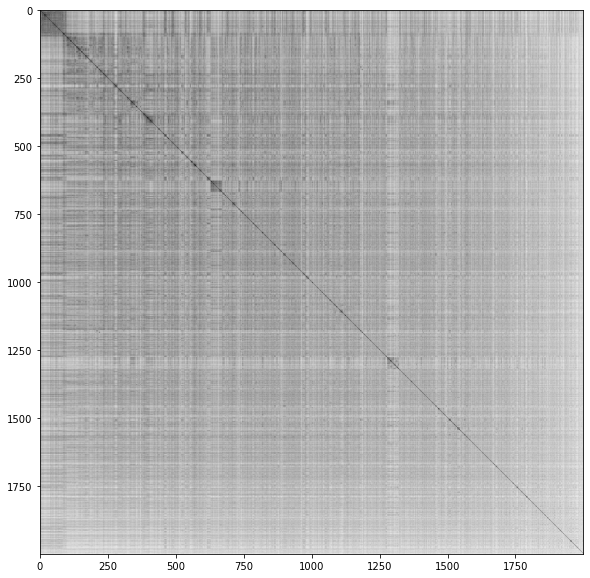

In [8]:
from pyclustertend import vat

#1000 and 5000 samples give very similar vat graph.
#adjustable: len count adjustable, but when it is greater than 3000, it will take time to draw a vat
if len(vlines) > 2000:
    samples = vlines[np.random.choice(vlines.shape[0], 2000, replace=False), :]
    vat(samples) #take data matrix, not dist matrix
else:
    vat(vlines)


## BIRCH clustering: upper level raw clustering 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

In [9]:
#adjustable: all three parameters are adjustable. 
#branching_factor: greater gives more natural cluatering results
#n_clusters: total clusters to output. If set to None, subclusters will be returned directly (and not merged into clusters)
#threshold: Euclidean distance threshold for merging subclusters. Sensitive. Set n_clusters to None and experiment with 0.5, 0.55, etc. to observe the number of subclusters generated.

brc = Birch(branching_factor=200, n_clusters=None, threshold=0.75) #n_clusters = None, meaning unlimited  
%time brc.fit(vlines) 


brc.subcluster_labels_






Wall time: 80.8 ms


Birch(branching_factor=200, n_clusters=None, threshold=0.75)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [10]:
labels = brc.predict(vlines)
df = pd.DataFrame({'src':df_content['src'], 'birchcluster':labels, 'content':plines, 'original':df_content['original']}) 
df 
tab = df.groupby(['src', 'birchcluster']).size()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(tab.unstack().transpose())
    
with open("clusters."+ds+".pkl", 'wb') as outp:
    pickle.dump(df, outp, pickle.HIGHEST_PROTOCOL)

,src,birchcluster,content,original
0,SMITHSONIAN,0,primary terra firma forest tall undergrowth,Primary terra firma forest with tall (3-5 m) u...
1,SMITHSONIAN,0,thorny scrub wet pasture,thorny scrub in wet pasture
2,SMITHSONIAN,0,ridgeline primary forest,ridgeline in primary forest
3,SMITHSONIAN,0,prosopis forest dense riparian undergrowth,Prosopis forest with dense riparian undergrowth
4,SMITHSONIAN,0,temperate rainforest,temperate rainforest
...,...,...,...,...
4241,SMITHSONIAN,1,endolithic,endolithic
4242,SMITHSONIAN,16,shady roadside ajdacent orchard canyon bottom ...,Shady roadside ajdacent to orchard near canyon...
4243,SMITHSONIAN,0,edge semi-humid forest,edge semi-humid forest
4244,SMITHSONIAN,0,cloud forest undergrowth,cloud forest undergrowth


src           SMITHSONIAN
birchcluster             
0                    1596
1                     527
2                       2
3                     871
4                       6
5                      13
6                      16
7                       1
8                      28
9                       1
10                    219
11                      1
12                      8
13                    498
14                      1
15                      5
16                    453


In [11]:
df[['content', 'birchcluster']]

,content,birchcluster
0,primary terra firma forest tall undergrowth,0
1,thorny scrub wet pasture,0
2,ridgeline primary forest,0
3,prosopis forest dense riparian undergrowth,0
4,temperate rainforest,0
...,...,...
4241,endolithic,1
4242,shady roadside ajdacent orchard canyon bottom ...,16
4243,edge semi-humid forest,0
4244,cloud forest undergrowth,0


In [12]:
#Gethering terms using TFIDF 

def gatherTerm(cframe, threshold):
    #adjustable: max_df: [0-1] maximal precentage of the documents containing the word, Set to 1 would make all words eligible, 0, no words eligible .
    #min_df: [0-1] minimal precentage of the documents containing the word, Set to 1 would make essentially no words eligible, 0, all words are eligible.
    #max_features: max number of eligible words will be selected to make the tfidf matrix
    #more settings see https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

    tfidf_vectorizer = TfidfVectorizer(max_df = 0.8, max_features=200, min_df=0.1, stop_words='english',
                                  use_idf=True)
    try:
        tfidf_matrix = tfidf_vectorizer.fit_transform(cframe['description'])
        terms = tfidf_vectorizer.get_feature_names()
        ordered_index = tfidf_matrix.toarray().argsort()[:, ::-1]
        allterms = []
        for i in range(0, len(cframe)):
            n_terms = []
            for ind in ordered_index[i,]: 
                if tfidf_matrix[i, ind] > threshold:
                    n_terms.append(terms[ind]) 
            allterms.append(n_terms)
        return allterms
        
    except ValueError:#no term obtained from tfidf when all records holds the same set of terms
        return []

In [13]:
#produce terms from Birch clustering result

frame = df[['birchcluster','content']]
frame = frame.rename(columns={'birchcluster':'cluster', 'content':'description'})
cframe =frame.groupby('cluster', as_index =False).agg({'description': ' '.join})
#adjustable: threshold > 0
terms = gatherTerm(cframe, threshold=0.1)
i=0
for term in terms:
    print('cluster '+ str(cframe.iloc[i]['cluster'])+':')
    print(term)
    i = i+1
    print()




cluster 0:
['forest', 'ecological', 'collector', 'yes', 'pine', 'edge', 'wet', 'scrub']

cluster 1:
['sand', 'rubble', 'white', 'rock', 'soil', 'rocks', 'sandy', 'growing', 'coral', 'large', 'dry', 'scrub', 'laterite', 'limestone']

cluster 2:
['water']

cluster 3:
['quercus', 'slopes', 'pinus', 'festuca', 'muhlenbergia', 'rocky', 'forest', 'poa', 'calamagrostis', 'juniperus', 'acacia', 'flats', 'steep', 'grassy']

cluster 4:
['rock']

cluster 5:
['exposed', 'deep', 'sand', 'lake', 'bed', 'ground']

cluster 6:
['dead', 'coral']

cluster 7:
[]

cluster 8:
['disturbed', 'roadside', 'vegetation', 'open', 'forest']

cluster 9:
['palm', 'acacia']

cluster 10:
['river', 'lake', 'marsh', 'sandy', 'beach', 'flats', 'dunes', 'small', 'shore', 'edge', 'sand', 'stream', 'coastal', 'wet', 'creek', 'scrub', 'saline']

cluster 11:
[]

cluster 12:
['base', 'tree', 'scrub', 'trail', 'roadside']

cluster 13:
['road', 'growing', 'roadside', 'edge', 'forest', 'field', 'area', 'stream', 'ecological', 'col

## clustering of subclusters of BIRCH result with parallal programming
https://www.machinelearningplus.com/python/parallel-processing-python/# not working!

https://github.com/yngvem/parallelising-python 

also see https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

https://github.com/mdimura/sparsehc-dm

https://pypi.org/project/fastcluster/

https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html


In [14]:
from fastcluster import linkage_vector
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram


#birchcluster_df: the input observation data (D=300xN)
#birchcluster_number:  cluster number of birchcluster_df in BIRCH result 
#min_obs: minimal observations in birchcluster_df to run hierarichal clustering, must be >=2

def h_clustering_fast(birchcluster_df, birchcluster_number, link_method, min_obs=2 ):
    #dist = pdist(birchcluster_df)
    print(birchcluster_number)
    if len(birchcluster_df) < min_obs:
        return [] 
    else:
        linkage_matrix = fastcluster.linkage_vector(birchcluster_df, link_method) #single, complete, average, weighted, median, centroid, ward
        return linkage_matrix
    
#result = h_clustering_fast(vlines[df.index[df['birchcluster']==0]], 0, 'ward', 20)
#result
    

In [15]:
#birchcluster_df: df holding the birchcluster observation content
#birchcluster_number:  cluster number of birchcluster_df in BIRCH result 
#linkage_matrix: the linkage_matrix for the birchcluster
#t: threshold to obtain clusters from hierarchical clustering for the specified criterion
#criterion: criterion used to obtain clusters

def obtain_h_clusters(birchcluster_df, birchcluster_number, linkage_matrix, t=10, criterion="maxclust"):
    if np.any(linkage_matrix):
        clusters = fcluster(linkage_matrix, t, criterion=criterion) #distance, inconsistency
       
        num_clusters = len(np.unique(clusters))
        
        birchcluster_df = birchcluster_df.reset_index()
        cresult = birchcluster_df[['index']]
        cresult['hcluster']= clusters
        
        records = {'description':df[df['birchcluster']==birchcluster_number].content, 'cluster':clusters, 'birchcluster':birchcluster_number}
        frame = pd.DataFrame(records, columns=['description', 'cluster', 'birchcluster'])
        cframe =frame.groupby('cluster', as_index = True).agg({'description': ' '.join})
        return cresult
    else:
        return []
    
    
#len(results)
#16 empty
#cresult = obtain_h_clusters(df[df['birchcluster']==3], 3, linkage_matrix=results[3], t=3 if df[df['birchcluster']==3].shape[0] < 100 else 10 , criterion="maxclust")
#cresult
    
       
            


In [16]:

results = []     
#adjustable: linkmethod: single, complete, average, weighted, median, centroid, ward. Not recommend 'single' for samples dataset.
#min_obs >= 2, minimal number of observations in a cluster to form further clusters
%time results = Parallel(n_jobs=8, verbose=1)(delayed(h_clustering_fast)(vlines[df.index[df['birchcluster']==c]], c, 'ward', 2)  for c in range(0, len(df.birchcluster.unique())))
print("# of linkage matrices obtained: "+str(len(results)))


cresultlist = []
#adjustable: t, number of final/leaf clusters from hierarchical clustering
for cresult in Parallel(n_jobs=8,verbose=1)(delayed(obtain_h_clusters)(df[df['birchcluster']==c], c, linkage_matrix=results[c], t=3 if df[df['birchcluster']==c].shape[0] < 100 else 10, criterion='maxclust') for c in range(0, len(df.birchcluster.unique()))):
    cresultlist.append(cresult)

combined = pd.DataFrame()
#concat list of cresult row-wise
for cresult in cresultlist:
    print("cresult:")
    print(cresult)
    if np.any(cresult):
        combined = pd.concat([combined, cresult], ignore_index=True)

   
combined.set_index('index', inplace=True)

print(df)
df = df.join(combined) 
print(df)
      



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Wall time: 1.88 s
# of linkage matrices obtained: 17
cresult:
      index  hcluster
0         0         3
1         1         7
2         2         3
3         3         5
4         4         3
...     ...       ...
1591   4234         8
1592   4235         7
1593   4240         5
1594   4243         2
1595   4244         3

[1596 rows x 2 columns]
cresult:
     index  hcluster
0       26         7
1       29        10
2       42         1
3       47         2
4       53         6
..     ...       ...
522   4229        10
523   4230        10
524   4238         5
525   4241         3
526   4245         4

[527 rows x 2 columns]
cresult:
   index  hcluster
0     56         1
1    406         1
cresult:
     index  hcluster
0       24         6
1       32         9
2       36         9
3       39         6
4       43         1
..     ...       ...
866   4212         3
867   4221         1
868   4228         7
869   4236         3
870   4239         5

[871 rows x 2 columns]
cresult:
   i

[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:    0.6s finished


In [17]:
#produce terms from Birch + hierarchical clustering results

df["cluster"] = df["birchcluster"].astype(str) +'-'+ df["hcluster"].astype(str)
frame = df[['cluster','content']]
frame = frame.rename(columns={'content':'description'})
cframe =frame.groupby('cluster', as_index = False).agg({'description': ' '.join})
terms = gatherTerm(cframe, 0.1)
i=0
allterms = list()
for term in terms:
    print('cluster '+cframe.iloc[i]['cluster']+':')
    print(term)
    i = i+1
    print()
    allterms.extend(term)

from collections import Counter
counter = Counter(allterms)
counter.most_common()
      


cluster 0-1.0:
['yes', 'ecological', 'collector', 'forest', 'tree']

cluster 0-10.0:
['pine', 'forest', 'mixed', 'oak', 'deciduous', 'woods', 'white', 'woodland']

cluster 0-2.0:
['forest', 'edge', 'savannah', 'gallery', 'scrub', 'slope', 'river']

cluster 0-3.0:
['forest', 'primary', 'tall', 'secondary']

cluster 0-4.0:
['forest', 'sand', 'white', 'soil', 'brown', 'riparian', 'sandy', 'dense', 'clay', 'sandstone', 'scrub', 'vegetation']

cluster 0-5.0:
['forest', 'grass', 'disturbed', 'wet', 'area', 'dry', 'pine', 'trees', 'meadows', 'thickets', 'meadow', 'shrubs', 'road', 'ground', 'pinus', 'quercus', 'dense']

cluster 0-6.0:
['mesic', 'savannah', 'alpine', 'savanna', 'grassland', 'low', 'pasture', 'forest', 'grass', 'riparian', 'ground', 'edge', 'tree', 'woodland', 'tall', 'island', 'shruby', 'subalpine', 'meadow', 'marsh']

cluster 0-7.0:
['forest', 'dry', 'wet', 'deciduous', 'open', 'meadow']

cluster 0-8.0:
['scrub', 'forest', 'savannah', 'acacia', 'oak', 'disturbed']

cluster 0-

[('forest', 18),
 ('rocky', 14),
 ('slopes', 14),
 ('scrub', 13),
 ('sand', 12),
 ('open', 10),
 ('wet', 9),
 ('growing', 9),
 ('small', 9),
 ('steep', 9),
 ('slope', 8),
 ('sandy', 8),
 ('meadow', 8),
 ('road', 8),
 ('roadside', 8),
 ('edge', 7),
 ('soil', 7),
 ('disturbed', 7),
 ('dry', 7),
 ('ground', 7),
 ('rocks', 7),
 ('water', 7),
 ('stream', 7),
 ('river', 6),
 ('area', 6),
 ('rock', 6),
 ('tree', 5),
 ('white', 5),
 ('brown', 5),
 ('sandstone', 5),
 ('vegetation', 5),
 ('pinus', 5),
 ('quercus', 5),
 ('alpine', 5),
 ('marsh', 5),
 ('acacia', 5),
 ('limestone', 5),
 ('large', 5),
 ('beach', 5),
 ('bed', 5),
 ('grassy', 5),
 ('festuca', 5),
 ('tall', 4),
 ('clay', 4),
 ('grass', 4),
 ('shrubs', 4),
 ('gravel', 4),
 ('field', 4),
 ('dunes', 4),
 ('flats', 4),
 ('coastal', 4),
 ('ditch', 4),
 ('valley', 4),
 ('creek', 4),
 ('shore', 4),
 ('steppe', 4),
 ('base', 4),
 ('trail', 4),
 ('yes', 3),
 ('ecological', 3),
 ('collector', 3),
 ('pine', 3),
 ('mixed', 3),
 ('savannah', 3),
 (